In [108]:
%load_ext autoreload
%autoreload 2
import synthetics
import waveform_tools
import matplotlib.pyplot as plt
import numpy as np
import obspy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dev notebook to sort out the negative frequency bugs in waveform_tools.

First generate a waveform with no dt* (and no frequency domain operations)

dt* = 0


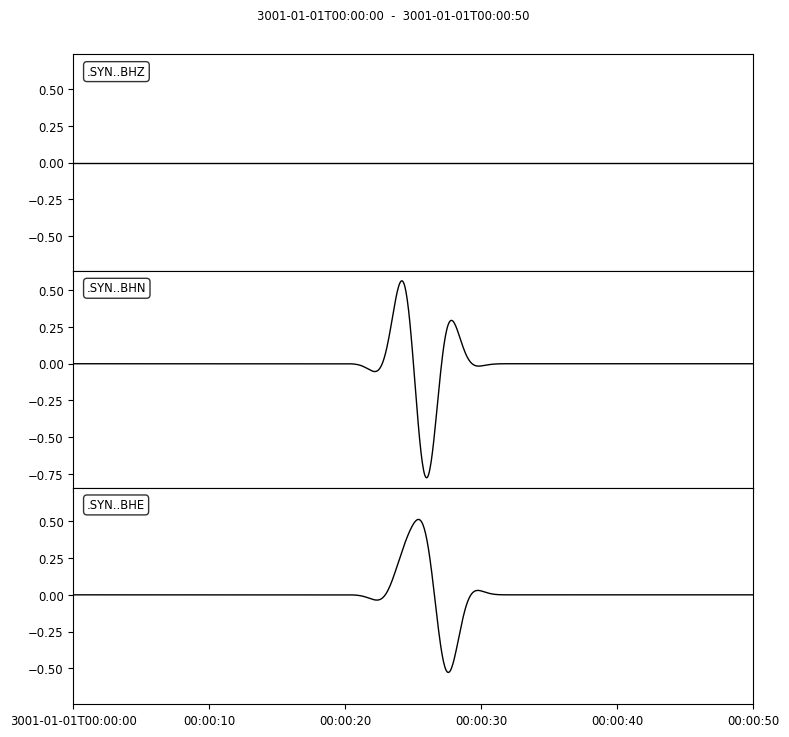

0.05

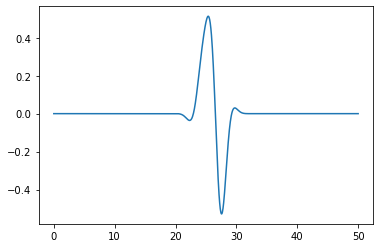

In [109]:
test = synthetics.gen_synthetic_split(30, 1.5, dtstar=0, nsamps=1001, noise=0, spol=80)
# Isolate one trace
test.plot()
tr = test[1].data
time = test[1].times()
plt.plot(time, tr)
test[0].stats.delta

Apply the interal dtstar function from wavefrom tools with NO dt*
This should not modify the waveform at all!

In [110]:
tr_out = waveform_tools.apply_tstar(tr.copy(), fref=1, delta=0.05, tstar=0)

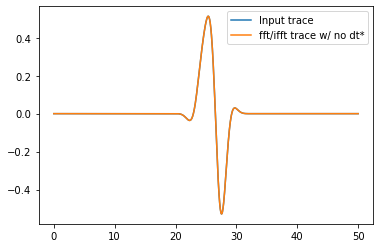

In [111]:
fig, ax = plt.subplots(1,1)
ax.plot(time, tr, label='Input trace')
ax.plot(time, tr_out, label='fft/ifft trace w/ no dt*')
ax.legend()
plt.show()

Here is the bug, we are NOT getting out what we put in for the fft and ifft
Lets pull apart the code from apply_tstar and make sure the negative frequencies are being handled properly (spolier - they aren't atm)

In [112]:
signal = tr.copy()
delta = 0.05
fref = 1
tstar = 1 
from scipy.fft import fft, ifft, fftfreq, next_fast_len
# Copy of the bugged version of apply_tstar, without the causual attenuation operator for now
# Take fft of trace. Supplying a larger n 0-pads trace.

nsamps = len(signal)
n = next_fast_len(nsamps)
# n = nsamps
fd_signal = fft(signal, n)
frequencies = fftfreq(n, d=delta)[0:n//2]
#Negative frequencies are in second half of array     

#get angular frequencies
ang_freqs = 2*np.pi*frequencies
ang_fref = 2*np.pi*fref
# Create causual t* multiplier 
aw_imag = (-1j)*(1/np.pi) * tstar * ang_freqs[1:] * np.log((ang_freqs[1:])/ang_fref)
aw_real = (-1/2)*ang_freqs[1:]*tstar
aw = np.ones(n//2, dtype=np.complex128())
aw[1:] = np.exp(aw_real + aw_imag)
# Apply t* operate to frequency domain signal
attenuated_fd_signal = np.zeros((int(n),), dtype=np.complex128())
attenuated_pos_f = fd_signal[0:n//2]*aw
attenuated_fd_signal[0:n//2] = attenuated_pos_f
# Restore symettry for negative frequencies
# index pos frequencies from 1 as we don't need to repeate f=0
attenuated_neg_f = np.conjugate(attenuated_pos_f[1:])
# index from [n//2+1] following scipy docs. if n is even then +/- nyquist frewquencies
# are aliased together
reversed_nef_f = np.flip(attenuated_neg_f).copy()
attenuated_fd_signal[n//2+1:] = np.flip(attenuated_neg_f)
# Take inverse fft
attenuated_signal = ifft(attenuated_fd_signal, n)[0:nsamps]

In [113]:
attenuated_signal.__len__()

1001

In [114]:
f = fftfreq(n, delta)
f[n//2]

-10.0

ValueError: x and y must have same first dimension, but have shapes (1008,) and (1001,)

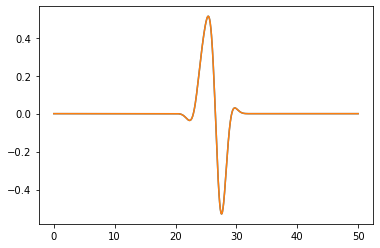

In [115]:
t1 =  np.arange(0,n)*0.05
fig, ax = plt.subplots(1,1)
ax.plot(time, tr, label='Input trace')
ax.plot(time, tr_out, label='fft/ifft trace w/ no dt*')
ax.plot(t1, attenuated_signal.real, label='attn signal')
ax.legend()
fig2, ax = plt.subplots(1,1)
ax.plot(time, (tr_out - attenuated_signal[0:nsamps].real))
plt.show()

## NB tstar =1 now so plots wont exactl match


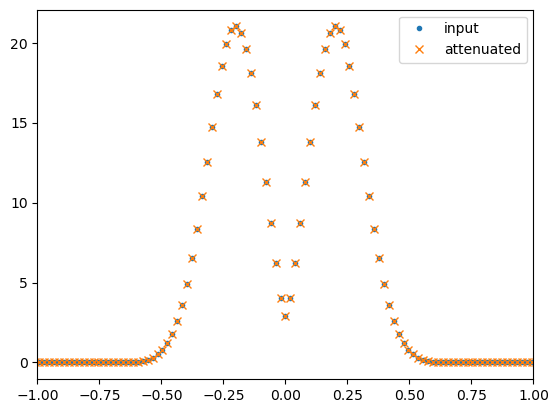

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(f, abs(fd_signal),'.', label='input')
ax.plot(f, abs(attenuated_fd_signal),'x', label='attenuated')
ax.set_xlim([-1,1])
ax.legend()

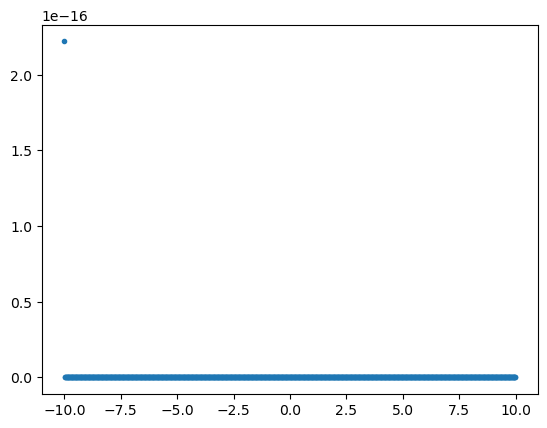

In [ ]:
fig, ax = plt.subplots(1,1)
# ax.plot(f, fd_signal.real ,'-')
ax.plot(f, (fd_signal.real - attenuated_fd_signal.real), '.')
# ax.plot(f, (fd_signal.imag - attenuated_fd_signal.imag), '.')

In [ ]:
fd_signal[n//2]  - attenuated_fd_signal[n//2]

(2.220446049250313e-16-0j)

Now try generating attenuated synthetics

dt* = 0


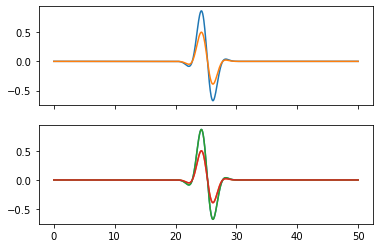

In [ ]:
fast = 30
syn1 = synthetics.gen_synthetic_split(fast, 1, dtstar=0)
syn2 = synthetics.gen_synthetic_split(fast, 1, dtstar=2)
# Now try to reproduce the dtstar manually
synF, synS = waveform_tools.rotate_traces(syn1[0], syn1[1], fast)
synmatch = waveform_tools.apply_tstar(synS, 1, 2, 0.05)
synS.data = synmatch
synN, synE = waveform_tools.rotate_traces(synF, synS, -1*fast)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(syn1[0].times(), syn1[0].data,
         syn1[1].times(), syn1[1].data)
ax2.plot(syn2[0].times(), syn2[0].data,
         syn2[1].times(), syn2[1].data,
         syn2[0].times(), synN.data,
         synN.times(), synE.data)



In [ ]:
synSA

array([0.00757778, 0.00754974, 0.0075217 , ..., 0.00766197, 0.00763389,
       0.00760583])

In [ ]:
synF.stats

         network: 
         station: SYN
        location: 
         channel: BHN
       starttime: 3001-01-01T00:00:00.000000Z
         endtime: 3001-01-01T00:00:50.000000Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 1001
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 0.05, 'b': -25.0, 'e': 25.0, 'baz': 30, 'evla': 0, 'evlo': 0, 'evdp': 500, 'stlo': 0, 'stla': 80, 'kstnm': 'SYN', 'a': -10.0, 'f': 10.0, 'user0': -10.0, 'user2': 10.0, 'cmpaz': 30, 'cmpinc': 90, 'cmpnm': 'BHN'})

Make sure that we are generating the correct t* 

In [ ]:
phi = 30
tlag = 1.5
dtstar =1
dfreq= 0.12
spol = 55
syn0  = synthetics.gen_synthetic_split(phi, tlag, dtstar=0, dfreq=dfreq, 
                                              spol=spol, nsamps=2001, delta=0.05)
syn1  = synthetics.gen_synthetic_split(phi, tlag, dtstar=1, dfreq=dfreq, 
                                              spol=spol, nsamps=2001, delta=0.05)
t = syn1[0].times()

dt* = 0


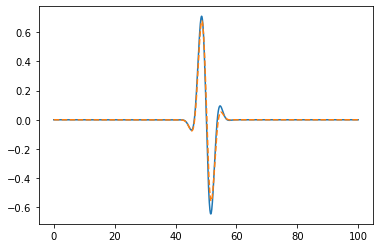

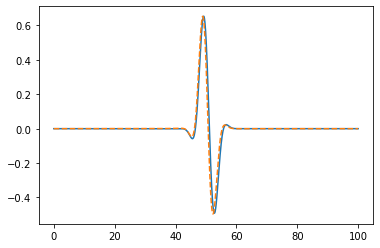

In [ ]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(t, syn0[0].data, '-')
ax1.plot(t, syn1[0].data, '--')

fig2, ax2 = plt.subplots(1,1)
ax2.plot(t, syn0[1].data, '-')
ax2.plot(t, syn1[1].data, '--')


Lets see if the real world noise is causing the issues.. 

In [ ]:
def add_noise(signal_in, snr):
    SYN_PATH = '/Users/ja17375/Projects/DeepMelt/SyntheticTest'
    signal = signal_in.copy()
    noise = obspy.read(f'{SYN_PATH}/data/NoiseSamples/noise_sample_50s.BH?')
    noise.rotate('NE->RT', back_azimuth=noise[0].stats.sac['baz'])
    signal.rotate('NE->RT',back_azimuth=signal[0].stats.sac['baz'])
    noise_comb = noise[0].data + noise[1].data
    nnoise = noise_comb / (2*noise_comb.std()) # normalise so noise std ~ 0.5, which gives a ~ SNR of 1
    # scale down noise by normalisng factor to get it to be roughly 1:1 with synthetics gain)
    scale_factor = 1/snr
    # now add noise to synthetics
    # Use approximation from Resitivo and Hellfrich that SNR = max(Rad)/2*std(Transverse)
    # So add noise to transverse signal
    signal[0].data = signal[0].data + nnoise*scale_factor*0.01
    signal[1].data = signal[1].data + nnoise*scale_factor
    signal[2].data = signal[2].data + noise[2].data*(scale_factor)
    signal.rotate('RT->NE', back_azimuth=signal[0].stats.sac['baz'])
    return signal


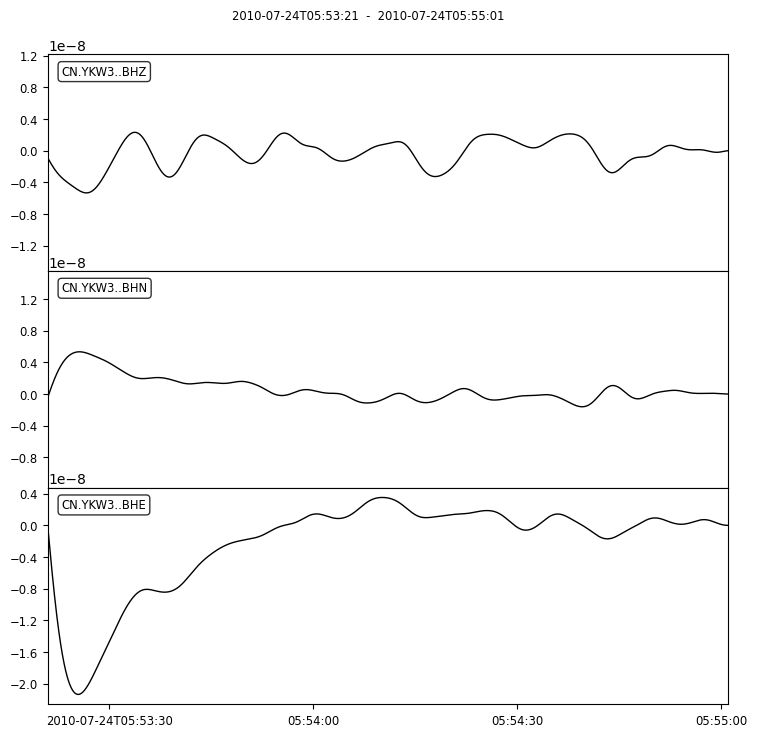

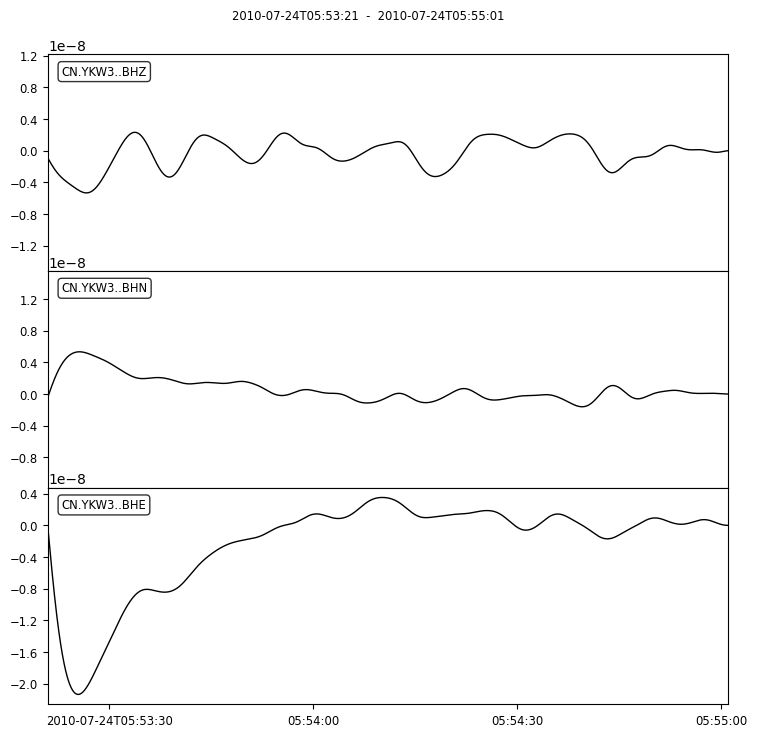

In [ ]:
SYN_PATH = '/Users/ja17375/Projects/DeepMelt/SyntheticTest'
noise = obspy.read(f'{SYN_PATH}/data/NoiseSamples/noise_sample_50s.BH?')
noise.plot()

In [ ]:
t = np.array([1,2,3,4,5])
t = np.flipud(t)
t

array([5, 4, 3, 2, 1])